# Oxygen Forecasting Model (Anomaly-Aware, Global Forecaster)

This notebook builds a **generic forecasting model** for minute-level oxygen readings,
using the **scored, processed dataset** from the anomaly detection pipeline.

According to the assignment requirements:

- We must build a **generic** forecaster that can work across multiple tags/customers
  without relying on tag semantics.
- The model should forecast **minute-level oxygen saturation**, ideally for the next
  1 week, while **handling anomalies**.

In this notebook we:

1. **Load** the scored, processed dataset (`oxygen_processed.csv`).
2. **Clean** the data by:
   - Removing rows with null timestamps or null oxygen values.
   - Removing highly anomalous records based on the **anomaly severity** score.
3. **Engineer time-series features** (lags + calendar features).
4. **Train an anomaly-aware global forecasting model** using all sensors together.
5. **Evaluate** the 1-step-ahead performance on a hold-out time window.
6. **Illustrate** how to generate a 1-week-ahead forecast for a single sensor
   via iterative predictions.


In [1]:
# %% Imports & plotting config

import numpy as np
import pandas as pd
import os
from pathlib import Path

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True

from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [2]:
DATA_DIR = os.path.abspath(os.path.join(os.getcwd(), "../" , "data"))
DATA_RAW_DIR = Path(os.path.join(DATA_DIR, "raw"))
DATA_PROCESSED_DIR = Path(os.path.join(DATA_DIR, "processed"))
# Path to the dataset (adjust this if needed)
processed_path = Path(os.path.join(DATA_PROCESSED_DIR, "oxygen_processed.csv"))

In [3]:
# %% Load the scored, processed dataset

# Path to the scored, processed dataset from the previous notebook
data_path = processed_path  # adjust if needed

df = pd.read_csv(data_path)

# Try to parse 'time' if present
if "time" in df.columns:
    df["time"] = pd.to_datetime(df["time"], errors="coerce")

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()


Shape: (1612639, 24)
Columns: ['Unnamed: 0', 'time', 'sensor_id', 'oxygen', 'hour', 'dayofweek', 'synthetic_label', 'roll_mean', 'roll_std', 'z_global', 'score_point', 'roll_mean_abs_z', 'score_collective', 'ctx_mean_hour', 'ctx_std_hour', 'z_context', 'score_context', 'roll_std_long', 'score_stuck', 'score_spike', 'roll_std_noise', 'score_noise', 'score_sensor_fault', 'severity']


,Unnamed: 0,time,sensor_id,oxygen,hour,dayofweek,synthetic_label,roll_mean,roll_std,z_global,...,ctx_std_hour,z_context,score_context,roll_std_long,score_stuck,score_spike,roll_std_noise,score_noise,score_sensor_fault,severity
0,0,2025-04-01 17:43:00,System_10|EquipmentUnit_05|nan,91.639549,17,1,normal,NaN,NaN,NaN,...,5.891127,0.679695,0.0,NaN,NaN,0.0,NaN,NaN,0.0,0.0
1,1,2025-04-01 17:44:00,System_10|EquipmentUnit_05|nan,91.443474,17,1,normal,NaN,NaN,NaN,...,5.891127,0.646412,0.0,NaN,NaN,0.0,NaN,NaN,0.0,0.0
2,2,2025-04-01 17:45:00,System_10|EquipmentUnit_05|nan,91.784111,17,1,normal,NaN,NaN,NaN,...,5.891127,0.704234,0.0,NaN,NaN,0.0,NaN,NaN,0.0,0.0
3,3,2025-04-01 17:46:00,System_10|EquipmentUnit_05|nan,92.180275,17,1,normal,NaN,NaN,NaN,...,5.891127,0.771482,0.0,NaN,NaN,0.0,NaN,NaN,0.0,0.0
4,4,2025-04-01 17:47:00,System_10|EquipmentUnit_05|nan,92.131180,17,1,normal,NaN,NaN,NaN,...,5.891127,0.763148,0.0,NaN,NaN,0.0,NaN,NaN,0.0,0.0


In [4]:
# %% Identify oxygen column and required fields

# Identify the oxygen column: either 'oxygen' or 'Oxygen[%sat]'
if "oxygen" in df.columns:
    value_col = "oxygen"
elif "Oxygen[%sat]" in df.columns:
    value_col = "Oxygen[%sat]"
else:
    raise ValueError(
        "Expected either 'oxygen' or 'Oxygen[%sat]' in columns. Found: "
        + ", ".join(df.columns)
    )

# Check severity column
if "severity" not in df.columns:
    raise ValueError(
        "Expected 'severity' column with anomaly severity scores in the processed dataset."
    )

# Ensure sensor_id exists (for grouping); if not, treat entire dataset as one series
if "sensor_id" not in df.columns:
    print("Warning: 'sensor_id' not found. Treating all data as a single global series.")
    df["sensor_id"] = "global"

df[[ "time", "sensor_id", value_col, "severity" ]].head()


,time,sensor_id,oxygen,severity
0,2025-04-01 17:43:00,System_10|EquipmentUnit_05|nan,91.639549,0.0
1,2025-04-01 17:44:00,System_10|EquipmentUnit_05|nan,91.443474,0.0
2,2025-04-01 17:45:00,System_10|EquipmentUnit_05|nan,91.784111,0.0
3,2025-04-01 17:46:00,System_10|EquipmentUnit_05|nan,92.180275,0.0
4,2025-04-01 17:47:00,System_10|EquipmentUnit_05|nan,92.131180,0.0


In [5]:
# %% Clean data: drop nulls and filter out highly anomalous points

# 1) Drop rows with null timestamps or null oxygen values
before_null = len(df)
df_clean = df[df["time"].notna() & df[value_col].notna()].copy()
after_null = len(df_clean)
print(f"Removed {before_null - after_null} rows due to null time or null {value_col}.")

# 2) Remove highly anomalous records based on severity score
#    Strategy: drop the top 1% most severe points (severity >= 99th percentile).
sev_q99 = df_clean["severity"].quantile(0.99)
print("99th percentile of severity:", sev_q99)

df_clean = df_clean[df_clean["severity"] < sev_q99].copy()
after_anom = len(df_clean)
print(f"Removed {after_null - after_anom} rows as 'highly anomalous' (severity >= q99).")

df_clean = df_clean.sort_values(["sensor_id", "time"]).reset_index(drop=True)
print("Final cleaned shape:", df_clean.shape)


Removed 0 rows due to null time or null oxygen.
99th percentile of severity: 0.9708921829569216
Removed 16127 rows as 'highly anomalous' (severity >= q99).
Final cleaned shape: (1596512, 24)


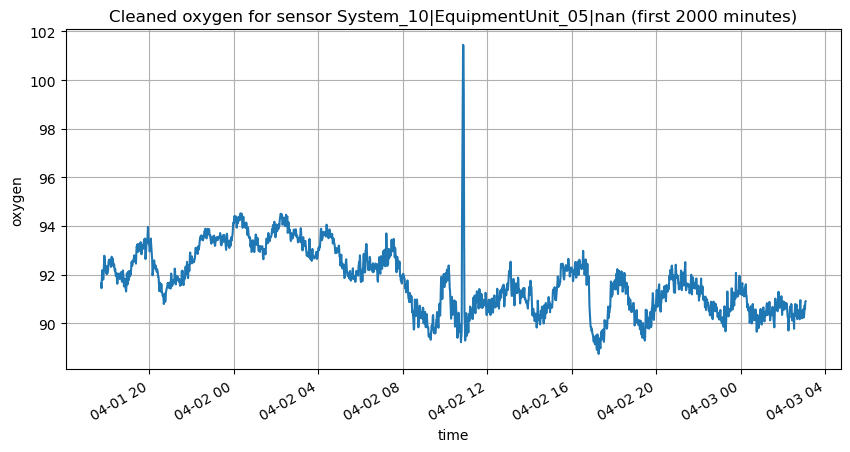

In [6]:
# %% Basic visual check for one sensor

sample_sensor = df_clean["sensor_id"].iloc[0]
mask = df_clean["sensor_id"] == sample_sensor

df_sample = df_clean.loc[mask].set_index("time").sort_index().iloc[:2000]

df_sample[value_col].plot()
plt.title(f"Cleaned oxygen for sensor {sample_sensor} (first 2000 minutes)")
plt.xlabel("time")
plt.ylabel(value_col)
plt.show()


In [7]:
# %% Feature engineering: lags + calendar features

df_feat = df_clean.copy()

# Time-based features
df_feat["minute_of_day"] = df_feat["time"].dt.hour * 60 + df_feat["time"].dt.minute
df_feat["dayofweek"] = df_feat["time"].dt.dayofweek

# Cyclical encoding for time-of-day (period = 1440 minutes)
df_feat["sin_time"] = np.sin(2 * np.pi * df_feat["minute_of_day"] / 1440)
df_feat["cos_time"] = np.cos(2 * np.pi * df_feat["minute_of_day"] / 1440)

# Cyclical encoding for day-of-week (period = 7)
df_feat["sin_dow"] = np.sin(2 * np.pi * df_feat["dayofweek"] / 7)
df_feat["cos_dow"] = np.cos(2 * np.pi * df_feat["dayofweek"] / 7)

# Lag features per sensor: 1, 5, 60 minutes
lag_steps = [1, 5, 60]
for lag in lag_steps:
    df_feat[f"lag_{lag}"] = (
        df_feat.groupby("sensor_id")[value_col]
        .shift(lag)
    )

# Rolling mean over 60 minutes as a smoothed baseline
df_feat["roll_mean_60"] = (
    df_feat.groupby("sensor_id")[value_col]
    .rolling(window=60, min_periods=30)
    .mean()
    .reset_index(level=0, drop=True)
)

# Drop rows where any feature is NaN (due to initial lags/rolls)
feature_cols = [
    f"lag_{lag}" for lag in lag_steps
] + [
    "roll_mean_60",
    "sin_time", "cos_time",
    "sin_dow", "cos_dow",
]

df_model = df_feat.dropna(subset=feature_cols + [value_col]).copy()
print("Shape after feature engineering & dropping NaNs:", df_model.shape)
df_model[[ "time", "sensor_id", value_col ] + feature_cols].head()


Shape after feature engineering & dropping NaNs: (1596212, 33)


,time,sensor_id,oxygen,lag_1,lag_5,lag_60,roll_mean_60,sin_time,cos_time,sin_dow,cos_dow
60,2025-04-01 18:43:00,System_10|EquipmentUnit_05|nan,91.887169,91.709824,91.887360,91.639549,92.177401,-0.982450,0.186524,0.781831,0.62349
61,2025-04-01 18:44:00,System_10|EquipmentUnit_05|nan,92.063385,91.887169,91.888031,91.443474,92.187733,-0.981627,0.190809,0.781831,0.62349
62,2025-04-01 18:45:00,System_10|EquipmentUnit_05|nan,92.172234,92.063385,92.106384,91.784111,92.194201,-0.980785,0.195090,0.781831,0.62349
63,2025-04-01 18:46:00,System_10|EquipmentUnit_05|nan,91.985451,92.172234,92.080818,92.180275,92.190954,-0.979925,0.199368,0.781831,0.62349
64,2025-04-01 18:47:00,System_10|EquipmentUnit_05|nan,91.686249,91.985451,91.709824,92.131180,92.183539,-0.979045,0.203642,0.781831,0.62349


In [8]:
# %% Train / validation split (time-based)

max_time = df_model["time"].max()
cutoff_time = max_time - pd.Timedelta(days=7)
print("Max time in dataset:", max_time)
print("Validation cutoff time:", cutoff_time)

train_mask = df_model["time"] < cutoff_time
valid_mask = df_model["time"] >= cutoff_time

train = df_model.loc[train_mask].copy()
valid = df_model.loc[valid_mask].copy()

print("Train shape:", train.shape)
print("Valid shape:", valid.shape)


Max time in dataset: 2025-11-14 09:31:00
Validation cutoff time: 2025-11-07 09:31:00
Train shape: (1545915, 33)
Valid shape: (50297, 33)


In [9]:
# %% Train the global forecasting model

X_train = train[feature_cols]
y_train = train[value_col]

X_valid = valid[feature_cols]
y_valid = valid[value_col]

print("Training samples:", X_train.shape[0])
print("Validation samples:", X_valid.shape[0])

# Global forecaster: HistGradientBoostingRegressor
forecaster = HistGradientBoostingRegressor(
    max_depth=None,
    learning_rate=0.05,
    max_iter=200,
    random_state=42
)

forecaster.fit(X_train, y_train)

print("Model trained.")


Training samples: 1545915
Validation samples: 50297
Model trained.


Validation MAE:  0.238
Validation RMSE: 0.404


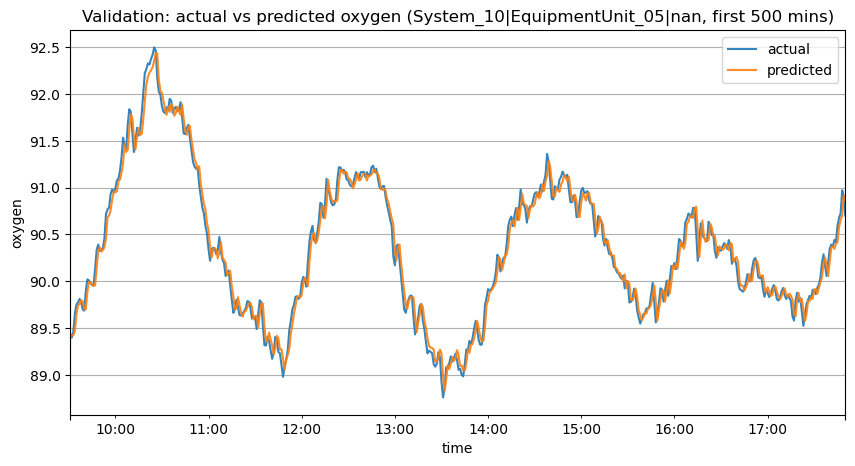

In [11]:
# %% Evaluate 1-step-ahead performance

y_pred_valid = forecaster.predict(X_valid)

mae = mean_absolute_error(y_valid, y_pred_valid)
mse = mean_squared_error(y_valid, y_pred_valid)

rmse = np.sqrt(mse)

print(f"Validation MAE:  {mae:.3f}")
print(f"Validation RMSE: {rmse:.3f}")

# Plot a small segment of predictions vs actuals for one sensor
sample_sensor = valid["sensor_id"].iloc[0]
mask = valid["sensor_id"] == sample_sensor

df_plot = valid.loc[mask, ["time", value_col]].copy()
df_plot["y_pred"] = y_pred_valid[mask.values]

df_plot = df_plot.set_index("time").sort_index().iloc[:500]

df_plot[[value_col, "y_pred"]].plot(alpha=0.9)
plt.title(f"Validation: actual vs predicted oxygen ({sample_sensor}, first 500 mins)")
plt.xlabel("time")
plt.ylabel(value_col)
plt.legend(["actual", "predicted"])
plt.show()


In [12]:
# %% 1-week-ahead forecast for a single sensor (iterative)

# Choose a sensor to forecast for
target_sensor = df_model["sensor_id"].iloc[0]
print("Target sensor for 1-week ahead forecast:", target_sensor)

sensor_hist = df_model[df_model["sensor_id"] == target_sensor].copy()
sensor_hist = sensor_hist.sort_values("time")

last_time = sensor_hist["time"].max()
print("Last observed time for sensor:", last_time)

# Number of minutes to forecast (1 week)
horizon_minutes = 7 * 24 * 60  # 10,080

# We'll keep a small working copy with only what we need
hist = sensor_hist[["time", value_col]].copy().reset_index(drop=True)

future_rows = []

current_time = last_time
for step in range(1, horizon_minutes + 1):
    current_time = current_time + pd.Timedelta(minutes=1)

    # Build feature row for current_time using the history (including previous forecasts)
    last_time_feat = current_time

    minute_of_day = last_time_feat.hour * 60 + last_time_feat.minute
    dayofweek = last_time_feat.dayofweek

    feat_row = {
        "minute_of_day": minute_of_day,
        "dayofweek": dayofweek,
        "sin_time": np.sin(2 * np.pi * minute_of_day / 1440),
        "cos_time": np.cos(2 * np.pi * minute_of_day / 1440),
        "sin_dow": np.sin(2 * np.pi * dayofweek / 7),
        "cos_dow": np.cos(2 * np.pi * dayofweek / 7),
    }

    # Ensure we have enough history; if not, break
    if len(hist) < max([1, 5, 60]) + 1:
        raise RuntimeError("Not enough history to create lag features for forecasting.")

    for lag in [1, 5, 60]:
        feat_row[f"lag_{lag}"] = hist[value_col].iloc[-lag]

    # Rolling mean over last 60 minutes
    last_60 = hist[value_col].iloc[-60:] if len(hist) >= 60 else hist[value_col]
    feat_row["roll_mean_60"] = last_60.mean()

    X_future = pd.DataFrame([feat_row])[feature_cols]

    y_future = forecaster.predict(X_future)[0]

    # Store forecast
    future_rows.append({"time": current_time, "sensor_id": target_sensor, "forecast": y_future})

    # Append the forecast to history for future lags
    hist = pd.concat(
        [hist, pd.DataFrame({"time": [current_time], value_col: [y_future]})],
        ignore_index=True
    )

df_future = pd.DataFrame(future_rows)
print("Forecast shape:", df_future.shape)
df_future.head()


Target sensor for 1-week ahead forecast: System_10|EquipmentUnit_05|nan
Last observed time for sensor: 2025-11-14 09:31:00
Forecast shape: (10080, 3)


,time,sensor_id,forecast
0,2025-11-14 09:32:00,System_10|EquipmentUnit_05|nan,91.980698
1,2025-11-14 09:33:00,System_10|EquipmentUnit_05|nan,91.991034
2,2025-11-14 09:34:00,System_10|EquipmentUnit_05|nan,91.977555
3,2025-11-14 09:35:00,System_10|EquipmentUnit_05|nan,91.982156
4,2025-11-14 09:36:00,System_10|EquipmentUnit_05|nan,91.965197


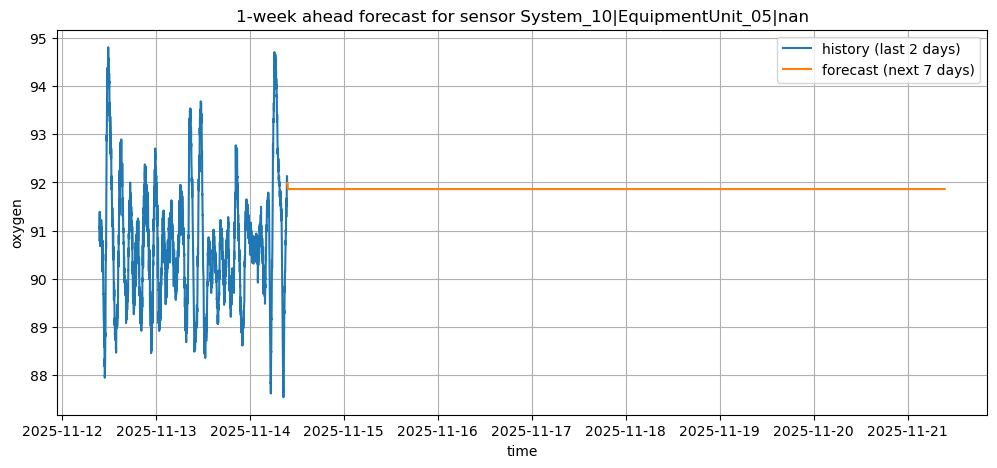

In [13]:
# %% Plot last 2 days of history + 1 week of forecast

history_days = 2
hist_window_start = last_time - pd.Timedelta(days=history_days)

hist_plot = sensor_hist[sensor_hist["time"] >= hist_window_start].copy()

plt.figure(figsize=(12, 5))

plt.plot(hist_plot["time"], hist_plot[value_col], label="history (last 2 days)")
plt.plot(df_future["time"], df_future["forecast"], label="forecast (next 7 days)")
plt.xlabel("time")
plt.ylabel(value_col)
plt.title(f"1-week ahead forecast for sensor {target_sensor}")
plt.legend()
plt.show()


## Summary & Next Steps

In this notebook we:

- Loaded the **scored, processed dataset** from the anomaly detection pipeline.
- Removed:
  - Rows with null timestamps or null oxygen values.
  - The top ~1% most anomalous minutes (based on the `severity` score),
    to avoid contaminating the forecaster with extreme events or sensor faults.
- Built a **global, tag-agnostic forecaster** using:
  - Lagged oxygen values (1, 5, 60 minutes),
  - A rolling 60-minute mean,
  - Cyclical time-of-day and day-of-week features.
- Trained a **HistGradientBoostingRegressor** on all sensors jointly
  (shared model, no tag-specific parameters).
- Evaluated 1-step-ahead performance on the last 7 days of data.
- Illustrated how to generate a **1-week-ahead forecast** for a single sensor
  via iterative prediction.

This design aligns with the assignment requirements by:

- Using a **single, generic model** (no reliance on specific tag values).
- Explicitly **handling anomalies** via the anomaly severity score.
- Supporting **minute-level forecasting** over multi-day horizons.

Possible extensions:

- Try other global forecasters (e.g. LSTM/GRU, Temporal Fusion Transformer)
  if you want more expressive models.
- Add more lags (e.g. 24-hour lag) and additional calendar features (month, season).
- Calibrate severity-based filtering and thresholds using a validation set
  or based on business tolerances for anomalies.
